# Active Learning (SDSS)

In [4]:
# remove after testing
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from mclearn.active import run_active_learning_expt
from mclearn.heuristics import (random_h, margin_h, entropy_h,
                                qbb_margin_h, qbb_kl_h, pool_entropy_h, pool_variance_h)
from mclearn.tools import results_exist, load_results
from mclearn.preprocessing import balanced_train_test_split
from mclearn.viz import plot_learning_curve_df, plot_final_accuracy, order_learning_curves
%matplotlib inline
sns.set_style('ticks')
sns.set_palette('Dark2', 8)

## Setting Up

In [6]:
running_expt = False # set to False if only want to load in results
fig_dir = '../thesis/figures/'
target_col = 'class'
sdss_features = ['psfMag_r_w14', 'psf_u_g_w14', 'psf_g_r_w14', 'psf_r_i_w14',
                'psf_i_z_w14', 'petroMag_r_w14', 'petro_u_g_w14', 'petro_g_r_w14',
                'petro_r_i_w14', 'petro_i_z_w14', 'petroRad_r']
xrange = np.arange(50, 301)
colors = {'Random': '#e6ab02',
          'Entropy': '#e7298a',
          'Margin': '#d95f02',
          'QBB Margin': '#1b9e77',
          'QBB KL': '#66a61e',
          'Pool Variance': '#7570b3',
          'Pool Entropy': '#a6761d',
          'Thompson': '#666666'}
linestyles = {'Random': '-',
              'Entropy': '-',
              'Margin': '-',
              'QBB Margin': '-',
              'QBB KL': '-',
              'Pool Variance': '-',
              'Pool Entropy': '-',
              'Thompson': '-'}
labels = ['Random', 'Entropy', 'Margin', 'QBB Margin', 'QBB KL', 'Pool Variance', 'Pool Entropy', 'Thompson']

In [7]:
if running_expt:
    sdss = pd.read_hdf('../data/sdss.h5', 'sdss')
    transformer = PolynomialFeatures(degree=2, interaction_only=False, include_bias=True)
    X = np.array(sdss[sdss_features])
    X_poly = transformer.fit_transform(X)
    y = np.array(sdss[target_col])

## Balanced: Logistic Regression

In [8]:
if running_expt:
    logistic = LogisticRegression(multi_class='ovr', penalty='l1', C=1, random_state=2, class_weight='auto')
    logistic_committee = BaggingClassifier(logistic, n_estimators=11, n_jobs=-1, max_samples=300)

    X_pool, _, y_pool, _ = balanced_train_test_split(X_poly, y, train_size=900000, test_size=0, random_state=11)
    kfold = StratifiedShuffleSplit(y_pool, n_iter=10, test_size=10000, train_size=10000, random_state=19)

In [9]:
heuristics = [random_h, entropy_h, margin_h, qbb_margin_h, qbb_kl_h, pool_variance_h, pool_entropy_h]
labels = ['Random', 'Entropy', 'Margin', 'QBB Margin', 'QBB KL', 'Thompson']
thompson_path = '../pickle/07_thompson_sampling/sdss_balanced_logistic_thompson.pickle'
pickle_paths = ['../pickle/06_active_learning/sdss_balanced_logistic_random.pickle',
                '../pickle/06_active_learning/sdss_balanced_logistic_entropy.pickle',
                '../pickle/06_active_learning/sdss_balanced_logistic_margin.pickle',
                '../pickle/06_active_learning/sdss_balanced_logistic_qbb_margin.pickle',
                '../pickle/06_active_learning/sdss_balanced_logistic_qbb_kl.pickle']

if not results_exist(pickle_paths):
    run_active_learning_expt(X_pool, y_pool, kfold, logistic, logistic_committee, heuristics, pickle_paths)

bl_lcs, bl_sels = zip(*load_results(pickle_paths))
bl_lcs = list(bl_lcs)
bl_lcs.append(load_results(thompson_path))
bl_df = order_learning_curves(bl_lcs, labels)
bl_df.columns

Index(['Margin', 'QBB Margin', 'Thompson', 'Entropy', 'Random', 'QBB KL'], dtype='object')

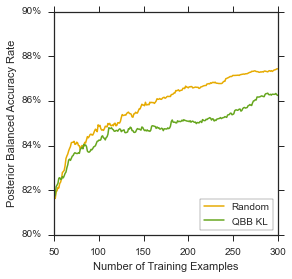

In [10]:
fig = plt.figure(figsize=(4, 4))
ax = plot_learning_curve_df(xrange, bl_df, bl_df.columns[4:], colors, linestyles, ylim=(.8, .9))
fig.savefig(fig_dir+'5_active/sdss_bl_ind_lower.pdf', bbox_inches='tight')

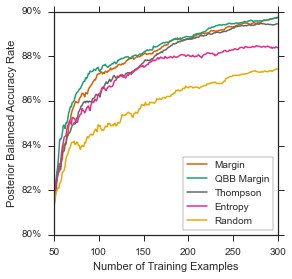

In [11]:
fig = plt.figure(figsize=(4, 4))
ax = plot_learning_curve_df(xrange, bl_df, bl_df.columns[:5], colors, linestyles, ylim=(.8, .9))
fig.savefig(fig_dir+'5_active/sdss_bl_ind_upper.pdf', bbox_inches='tight')

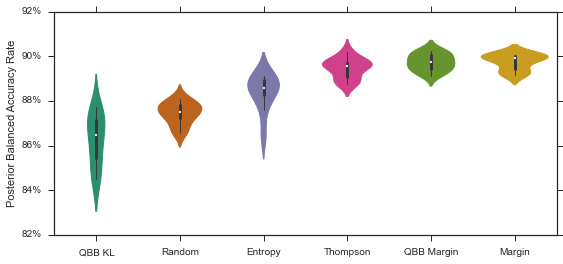

In [12]:
fig = plt.figure(figsize=(9, 4))
ax = plot_final_accuracy(bl_lcs, labels)
fig.savefig(fig_dir+'5_active/sdss_bl_ind_violin.pdf', bbox_inches='tight')

## Balanced: SVM RBF

In [13]:
if running_expt:
    rbf = SVC(kernel='rbf', gamma=0.1, C=10, cache_size=2000, class_weight='auto', probability=True)
    rbf_committee = BaggingClassifier(rbf, n_estimators=11, n_jobs=-1, max_samples=300)

    X_pool, _, y_pool, _ = balanced_train_test_split(X, y, train_size=900000, test_size=0, random_state=11)
    kfold = StratifiedShuffleSplit(y_pool, n_iter=10, test_size=10000, train_size=10000, random_state=19)

In [28]:
labels = ['Random', 'Entropy', 'Margin', 'QBB Margin', 'QBB KL', 'Pool Variance', 'Pool Entropy', 'Thompson']
heuristics = [random_h, entropy_h, margin_h, qbb_margin_h, qbb_kl_h, pool_variance_h, pool_entropy_h]
thompson_path = '../pickle/07_thompson_sampling/sdss_balanced_rbf_thompson.pickle'
pickle_paths = ['../pickle/06_active_learning/sdss_balanced_rbf_random.pickle',
                '../pickle/06_active_learning/sdss_balanced_rbf_entropy.pickle',
                '../pickle/06_active_learning/sdss_balanced_rbf_margin.pickle',
                '../pickle/06_active_learning/sdss_balanced_rbf_qbb_margin.pickle',
                '../pickle/06_active_learning/sdss_balanced_rbf_qbb_kl.pickle',
                '../pickle/06_active_learning/sdss_balanced_rbf_pool_variance.pickle',
                '../pickle/06_active_learning/sdss_balanced_rbf_pool_entropy.pickle']

if not results_exist(pickle_paths):
    run_active_learning_expt(X_pool, y_pool, kfold, rbf, rbf_committee, heuristics, pickle_paths)

br_lcs, br_sels = zip(*load_results(pickle_paths))
br_lcs = list(br_lcs)
br_lcs.append(load_results(thompson_path))
br_df = order_learning_curves(br_lcs, labels)
br_df.columns

Index(['Margin', 'QBB Margin', 'Thompson', 'Entropy', 'QBB KL', 'Random',
       'Pool Entropy', 'Pool Variance'],
      dtype='object')

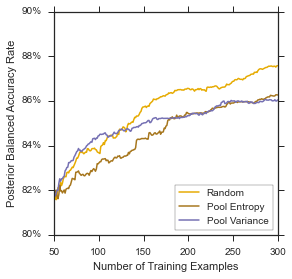

In [29]:
fig = plt.figure(figsize=(4, 4))
ax = plot_learning_curve_df(xrange, br_df, br_df.columns[5:], colors, linestyles, ylim=(.8, .9))
fig.savefig(fig_dir+'5_active/sdss_br_ind_lower.pdf', bbox_inches='tight')

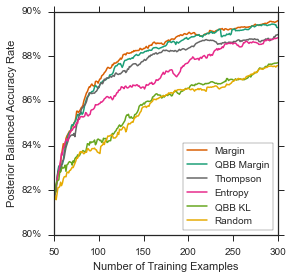

In [31]:
fig = plt.figure(figsize=(4, 4))
ax = plot_learning_curve_df(xrange, br_df, br_df.columns[:6], colors, linestyles, ylim=(.8, .9))
fig.savefig(fig_dir+'5_active/sdss_br_ind_upper.pdf', bbox_inches='tight')

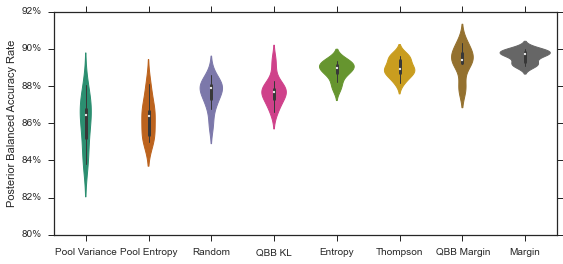

In [17]:
fig = plt.figure(figsize=(9, 4))
ax = plot_final_accuracy(br_lcs, labels)
fig.savefig(fig_dir+'5_active/sdss_br_ind_violin.pdf', bbox_inches='tight')

## Unbalanced: Logistic Regreesion

In [18]:
if running_expt:
    logistic = LogisticRegression(multi_class='ovr', penalty='l1', C=1, random_state=2, class_weight='auto')
    logistic_committee = BaggingClassifier(logistic, n_estimators=11, n_jobs=-1, max_samples=300)

    kfold = StratifiedShuffleSplit(y, n_iter=10, test_size=10000, train_size=10000, random_state=19)

In [19]:
labels = ['Random', 'Entropy', 'Margin', 'QBB Margin', 'QBB KL', 'Thompson']
heuristics = [random_h, entropy_h, margin_h, qbb_margin_h, qbb_kl_h, pool_variance_h, pool_entropy_h]
thompson_path = '../pickle/07_thompson_sampling/sdss_unbalanced_logistic_thompson.pickle'
pickle_paths = ['../pickle/06_active_learning/sdss_unbalanced_logistic_random.pickle',
                '../pickle/06_active_learning/sdss_unbalanced_logistic_entropy.pickle',
                '../pickle/06_active_learning/sdss_unbalanced_logistic_margin.pickle',
                '../pickle/06_active_learning/sdss_unbalanced_logistic_qbb_margin.pickle',
                '../pickle/06_active_learning/sdss_unbalanced_logistic_qbb_kl.pickle',]

if not results_exist(pickle_paths):
    run_active_learning_expt(X_poly, y, kfold, logistic, logistic_committee, heuristics, pickle_paths)

ul_lcs, ul_sels = zip(*load_results(pickle_paths))
ul_lcs = list(ul_lcs)
ul_lcs.append(load_results(thompson_path))
ul_df = order_learning_curves(ul_lcs, labels)
ul_df.columns

Index(['Margin', 'QBB Margin', 'Thompson', 'Entropy', 'Random', 'QBB KL'], dtype='object')

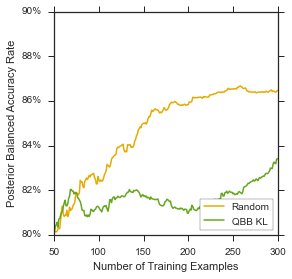

In [20]:
fig = plt.figure(figsize=(4, 4))
ax = plot_learning_curve_df(xrange, ul_df, ul_df.columns[4:], colors, linestyles, ylim=(.8, .9))
fig.savefig(fig_dir+'5_active/sdss_ul_ind_lower.pdf', bbox_inches='tight')

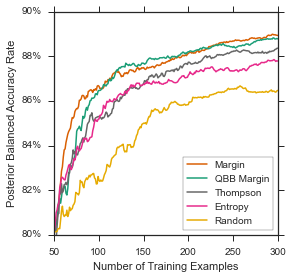

In [21]:
fig = plt.figure(figsize=(4, 4))
ax = plot_learning_curve_df(xrange, ul_df, ul_df.columns[:5], colors, linestyles, ylim=(.8, .9))
fig.savefig(fig_dir+'5_active/sdss_ul_ind_upper.pdf', bbox_inches='tight')

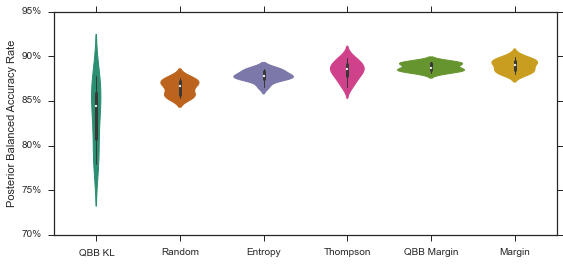

In [22]:
fig = plt.figure(figsize=(9, 4))
ax = plot_final_accuracy(ul_lcs, labels)
fig.savefig(fig_dir+'5_active/sdss_ul_ind_violin.pdf', bbox_inches='tight')

## Unbalanced: SVM RBF

In [23]:
if running_expt:
    rbf = SVC(kernel='rbf', gamma=0.1, C=10, cache_size=2000, class_weight='auto', probability=True)
    rbf_committee = BaggingClassifier(rbf, n_estimators=11, n_jobs=-1, max_samples=300)

    kfold = StratifiedShuffleSplit(y, n_iter=10, test_size=10000, train_size=10000, random_state=19)

In [32]:
labels = ['Random', 'Entropy', 'Margin', 'QBB Margin', 'QBB KL', 'Pool Variance', 'Pool Entropy', 'Thompson']
heuristics = [random_h, entropy_h, margin_h, qbb_margin_h, qbb_kl_h, pool_variance_h, pool_entropy_h]
thompson_path = '../pickle/07_thompson_sampling/sdss_unbalanced_rbf_thompson.pickle'
pickle_paths = ['../pickle/06_active_learning/sdss_unbalanced_rbf_random.pickle',
                '../pickle/06_active_learning/sdss_unbalanced_rbf_entropy.pickle',
                '../pickle/06_active_learning/sdss_unbalanced_rbf_margin.pickle',
                '../pickle/06_active_learning/sdss_unbalanced_rbf_qbb_margin.pickle',
                '../pickle/06_active_learning/sdss_unbalanced_rbf_qbb_kl.pickle',
                '../pickle/06_active_learning/sdss_unbalanced_rbf_pool_variance.pickle',
                '../pickle/06_active_learning/sdss_unbalanced_rbf_pool_entropy.pickle']

if not results_exist(pickle_paths):
    run_active_learning_expt(X, y, kfold, rbf, rbf_committee, heuristics, pickle_paths)

ur_lcs, ur_sels = zip(*load_results(pickle_paths))
ur_lcs = list(ur_lcs)
ur_lcs.append(load_results(thompson_path))
ur_df = order_learning_curves(ur_lcs, labels)
ur_df.columns

Index(['QBB Margin', 'Margin', 'Thompson', 'Entropy', 'QBB KL', 'Random',
       'Pool Entropy', 'Pool Variance'],
      dtype='object')

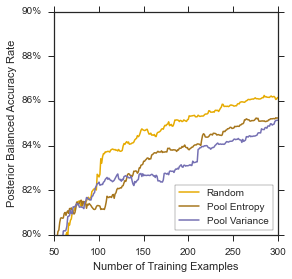

In [33]:
fig = plt.figure(figsize=(4, 4))
ax = plot_learning_curve_df(xrange, ur_df, ur_df.columns[5:], colors, linestyles, ylim=(.8, .9))
fig.savefig(fig_dir+'5_active/sdss_ur_ind_lower.pdf', bbox_inches='tight')

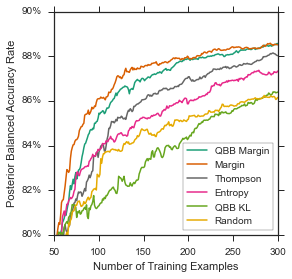

In [34]:
fig = plt.figure(figsize=(4, 4))
ax = plot_learning_curve_df(xrange, ur_df, ur_df.columns[:6], colors, linestyles, ylim=(.8, .9))
fig.savefig(fig_dir+'5_active/sdss_ur_ind_upper.pdf', bbox_inches='tight')

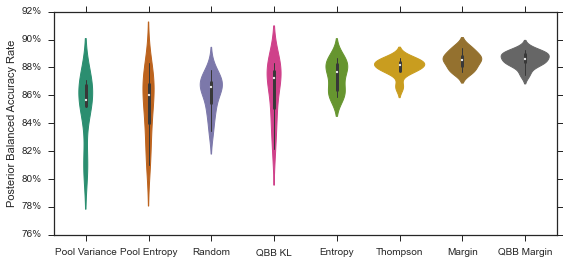

In [27]:
fig = plt.figure(figsize=(9, 4))
ax = plot_final_accuracy(ur_lcs, labels)
fig.savefig(fig_dir+'5_active/sdss_ur_ind_violin.pdf', bbox_inches='tight')